In [1]:
import numpy as np
from scipy.stats import entropy
import json
import collections
import itertools

from jointpdf.jointpdf import JointProbabilityMatrix
from jointpdf.jointpdf import FullNestedArrayOfProbabilities
from probability_distributions import JointProbabilityMatrixExtended
import probability_distributions
from probability_distributions import ProbabilityArray

import nudge

In [2]:
pdf = JointProbabilityMatrix(2, 5, 'random')
#pdf.append_variables_with_target_mi(1, 0.5)
#pdf.append_synergistic_variables(1)


In [3]:
NUDGE_SIZE = 0.01

pdf = JointProbabilityMatrix(1, 6, 'random')
#print(pdf.joint_probabilities.joint_probabilities)
pdf.append_variables_with_target_mi(1, 0.1)
#print(pdf.joint_probabilities.joint_probabilities)
#print(pdf.mutual_information([0], [1]))

joint_old = pdf.joint_probabilities.joint_probabilities
probability_array_old = ProbabilityArray(joint_old)
marginal_variable_old = probability_array_old.marginalize(set([0]))
marginal_function_old = probability_array_old.marginalize(set([1]))
conditional_joint_old, marginal_labels_old, conditional_labels_old = (
    probability_array_old.find_conditional(set([1]), set([0]))
)
#print(marginal_variable_old)
#print(np.allclose(
#    probability_distributions.compute_joint(
#        marginal_variable_old, conditional_joint_old, conditional_labels_old
#    ),
#    joint_old
#))
marginal_variable_nudged, nudged_states = nudge.nudge(marginal_variable_old, NUDGE_SIZE)
joint_new = ProbabilityArray(probability_distributions.compute_joint(
    marginal_variable_nudged, conditional_joint_old, conditional_labels_old
))
#This takes the KL-divergence between the new and old function variable
marginal_function_new = joint_new.marginalize(set([1]))  

kl_variable = entropy(marginal_variable_old, marginal_variable_nudged)
kl_function = entropy(marginal_function_old, marginal_function_new) 
print("KL-divergence old and new function distribution: {}".format(kl_variable))
print("KL-divergence old and new function distribution: {}".format(kl_function))




KL-divergence old and new function distribution: 0.000544031274326
KL-divergence old and new function distribution: 7.04112499329e-06


In [4]:
def effect_of_nudge_1d(distribution, nudge_size):
    """
    Nudge the input variable and calculate the effect on the output variable
    (the KL-devergence of the output variable)
    
    Parameters:
    ----------
    distribution: a numpy array
        It should represent the joint probability distribution of 1 input
        (the first axis) and 1 output variable (the second axis).
    nudge_size: a number
    
    Returns: a number
    """
    probability_array_old = ProbabilityArray(distribution)
    marginal_variable_old = probability_array_old.marginalize(set([0]))
    marginal_function_old = probability_array_old.marginalize(set([1]))
    conditional_joint_old, marginal_labels_old, conditional_labels_old = (
        probability_array_old.find_conditional(set([1]), set([0]))
    )
    marginal_variable_nudged, nudges_states = nudge.nudge(
        marginal_variable_old, NUDGE_SIZE
    )
    joint_new = ProbabilityArray(probability_distributions.compute_joint(
        marginal_variable_nudged, conditional_joint_old, conditional_labels_old
    ))
    marginal_function_new = joint_new.marginalize(set([1]))  
    kl_variable = entropy(marginal_variable_old, marginal_variable_nudged)
    kl_function = entropy(marginal_function_old, marginal_function_new) 
    return kl_variable, kl_function

pdf = JointProbabilityMatrix(1, 10, 'random')
pdf.append_variables_with_target_mi(1, 0.5)
distribution = pdf.joint_probabilities.joint_probabilities
effect_of_nudge_1d(distribution, 0.01)

(0.0043864353995366409, 4.3868000719459202e-05)

In [5]:
#see whether and how mutual information and response to the nudge co-depend
NUMBER_OF_STATES, NUDGE_SIZE = 6, 0.01
mutual_information_sizes = np.arange(0.05, 1, 0.05)
sample_size = 1
effect_nudge_given_mi = {}

for mutual_information_size in mutual_information_sizes:
    print("the mutual information size is {}".format(mutual_information_size))
    nudge_effects = []
    for sample in range(sample_size):
        pdf = JointProbabilityMatrix(1, NUMBER_OF_STATES, 'random')
        pdf.append_variables_with_target_mi(1, mutual_information_size)
        distribution = pdf.joint_probabilities.joint_probabilities
        nudge_effects.append(effect_of_nudge_1d(distribution, 0.01)[1])
        
    effect_nudge_given_mi[mutual_information_size] = nudge_effects
    #with open("back_up2.json", 'w') as f:
    #    json.dump(effect_nudge_given_mi, f)
    
#print(effect_nudge_given_mi)

the mutual information size is 0.05
the mutual information size is 0.1
the mutual information size is 0.15
the mutual information size is 0.2
the mutual information size is 0.25
the mutual information size is 0.3
the mutual information size is 0.35
the mutual information size is 0.4
the mutual information size is 0.45
the mutual information size is 0.5
the mutual information size is 0.55
the mutual information size is 0.6
the mutual information size is 0.65
the mutual information size is 0.7
the mutual information size is 0.75
the mutual information size is 0.8
the mutual information size is 0.85
the mutual information size is 0.9
the mutual information size is 0.95


In [6]:
def calculate_batch_std(samples_ord_dict, batch_size):
    """
    Calculate the standard deviation of the batches
    
    Parameters:
    ----------
    samples_ord_dict: an OrderedDict
    batch_size: an integer 
    
    """
    batches_std = []
    for measure, samples in samples_ord_dict.items():
        batched_estimates = []
        for i in range(len(samples)/batch_size):
            batched_estimates.append(
                np.mean(samples[i*batch_size:(i+1)*batch_size])
            )

        batches_std.append(np.std(batched_estimates))

    return batches_std

def find_mean_std_mse(samples_dict, batch_size=None):
    """
    For experiment find for every value the mean, the standard deviation,
    and the standard deviation of the batches
    
    Parameters:
    ----------
    samples_dict: a dict
        Every key in the dict represent some quantity of a variable
        of interest, i.e. the number of variables. The value should be
        an iterable of samples gathered
    batch_size: integer
        Should be a divisor of the number of samples in samples dict
        
    Returns:plot_range, mean, standard_deviation, batch_MSE
    -------
    plot_range: iterable
        An iterable containing the values for which the experiment 
        was performed
    mean: iterable
        The mean value for every value the experiment was performed
    standard_deviation: iterable
        The standard deviation for every value of the experiment
    batch_std: None, if batch_size is None, otherwise iterable 
        represent the standard deviation for the batches
        
    """
    sorted_ordered_samples_dict = collections.OrderedDict(
        sorted(samples_dict.items(), key=lambda x: x[0])
    )
    plot_range = sorted_ordered_samples_dict.keys()
    mean = [np.mean(samples) for samples 
            in sorted_ordered_samples_dict.values()]
    standard_deviation = [np.std(samples) for samples 
                          in sorted_ordered_samples_dict.values()]

    if batch_size is None:
        return plot_range, mean, standard_deviation, None
    else:
        if len(list(samples_dict.values())[0])%batch_size != 0:
            raise ValueError("batch size should be a divisor of the number of samples")
            
        batches_std = calculate_batch_std(sorted_ordered_samples_dict, batch_size)
        
    return plot_range, mean, standard_deviation, batches_std

tryout_dict = {
    'a': [1, 4, 6, 8, 9, 7],
    'b': [10, 2, 5, 3, 6, 1],
    'x': [8, 3, 1, 3, 6, 17],
    'e': [1, 7, 6, 5, 19, 7]
}

tryout_dict_sorted = collections.OrderedDict(
    sorted(tryout_dict.items(), key=lambda x: x[0])
)

print(calculate_batch_std(tryout_dict_sorted, 2))


BATCH_SIZE = 2
batches_mean_squared_error = {}
for mi, effect_nudge_list in tryout_dict.items():
    batched_estimates = []
    for i in range(len(effect_nudge_list)/BATCH_SIZE):
        batched_estimates.append(
            np.mean(effect_nudge_list[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
        )
      
    batches_mean_squared_error[mi] = np.std(batched_estimates)

print(batches_mean_squared_error)


[2.3921166824012206, 1.0801234497346435, 3.9370039370059056, 3.9228674319799399]
{'a': 2.3921166824012206, 'x': 3.9228674319799399, 'b': 1.0801234497346435, 'e': 3.9370039370059056}


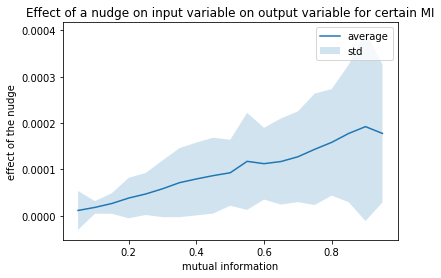

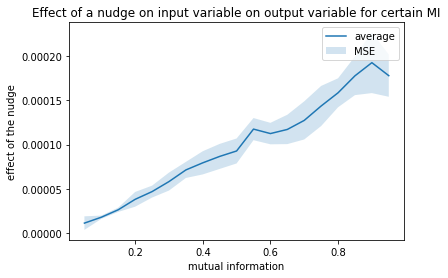

In [7]:
import plotting

with open("data_1_random_input_1_output_diff_MI.json", 'r') as f:
    first = json.load(f)

effect_nudge_given_mi = {}
    
for k, v in first.items():
    effect_nudge_given_mi[float(k)] = v
    
average_effect_nudge_dict = {k:np.mean(v) for k,v in effect_nudge_given_mi.items()}
standard_deviation_effect_nudge_dict = {k:np.std(v) for k,v in effect_nudge_given_mi.items()}

BATCH_SIZE = 30
batches_mean_squared_error = {}
for mi, effect_nudge_list in effect_nudge_given_mi.items():
    batched_estimates = []
    for i in range(len(effect_nudge_list)/BATCH_SIZE):
        batched_estimates.append(
            np.mean(effect_nudge_list[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
        )
    batches_mean_squared_error[mi] = np.std(batched_estimates)

batch_std_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(batches_mean_squared_error.items(), key= lambda x: x[0])
)    
average_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(average_effect_nudge_dict.items(), key= lambda x: x[0])
)
std_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(standard_deviation_effect_nudge_dict.items(), key= lambda x: x[0])
)

mi_values = average_effect_nudge_ord_dict.keys()
mean_effect_nudge = average_effect_nudge_ord_dict.values()
std_effect_nudge = std_effect_nudge_ord_dict.values()
batch_std_effect_nudge = batch_std_effect_nudge_ord_dict.values()

xlabel = "mutual information"
ylabel = "effect of the nudge"
title = "Effect of a nudge on input variable on output variable for certain MI"
plotting.plot_mean_and_confidence(
    mi_values, mean_effect_nudge, std_effect_nudge,
    "std", xlabel, ylabel, title
)
plotting.plot_mean_and_confidence(
    mi_values, mean_effect_nudge, batch_std_effect_nudge,
    "MSE", xlabel, ylabel, title
)

mi_values1, mean_effect_nudge1, std_effect_nudge1, batch_std_effect_nudge1 = (
    find_mean_std_mse(effect_nudge_given_mi, batch_size=30)
)

#print(np.allclose(mi_values1, mi_values))
#print(np.allclose(mean_effect_nudge1, mean_effect_nudge))
#print(np.allclose(std_effect_nudge1, std_effect_nudge))
#print(np.allclose(batch_std_effect_nudge1, batch_std_effect_nudge))


In [33]:
import copy

#this method does ot work, the joint does not sum to 1!!!
def update_joint_independent_marginals(joint, label_marginal, marginal, 
                                       update_states, other_marginal):
    """update a joint distribution only for certain states of a marginal
    assuming the merginals are independent for those states
    
    Parameters:
    ----------
    joint: numpy array
    label_marginal: integer
    marginal: a numpy array
    states: a numpy array
    other_marginal: a numpy array
    
    Returns: The updated joint distribution

    """
    updated_joint = np.copy(joint)
    states_input_variables = [range(states) for states in joint.shape]
    states_input_variables[label_marginal] = list(update_states)
    
    for state in itertools.product(*states_input_variables):
        state_other_input_variables = tuple([index for count, index in enumerate(state)
                                             if count != label_marginal])
        updated_joint[state] = (other_marginal[state_other_input_variables] *
                                marginal_variable_nudged[state[label_marginal]])

    return updated_joint

def nudge_distribution_local_non_causal1(joint, nudge_label, nudge_size):
    """
    Nudge the marginal and assume independence after the nudge to find the
    new joint.
    
    Parameters:
    ----------
    joint: a numpy array
        Representing a discrete probability distribution
    nudge_label: an integer
    nudge_size: a (small) number
    number_of_nudges: an integer
    
    """
    other_variables_labels = set(range(len(joint.shape))) - set([nudge_label]) 
    marginal_nudge_variable = ProbabilityArray(joint).marginalize(nudge_label)
    marginal_other_variables = ProbabilityArray(joint).marginalize(other_variables_labels)
    marginal_variable_nudged, nudged_states = nudge.nudge(marginal_nudge_variable, nudge_size)
    return probability_distributions.compute_joint_from_independent_marginals(
        marginal_other_variables, marginal_variable_nudged, sorted(list(label_nudged_variable))
    )

def nudge_distribution_local_non_causal2(joint, nudge_label, nudge_size, number_of_nudges):
    """
    nudge the the variable with nudge label while keeping the 
    marginal of the other variables constant
    
    Parameters:
    ----------
    joint: a numpy array
        Representing a discrete probability distribution
    nudge_label: an integer
    nudge_size: a (small) number
    number_of_nudges: an integer
    
    """
    nudged_joint = np.copy(joint)
    nudged_joint = nudged_joint.swapaxes(nudge_label, len(joint.shape)-1)
    nudge_states = nudge.select_random_states(nudged_joint.shape[:-1], number_of_nudges) 
    
    nudged_states_marginal = np.random.choice(joint.shape[nudge_label], 2, replace=False)
    nudge_state_plus, nudge_state_minus = nudged_states_marginal[0], nudged_states_marginal[1]   
    for state in nudge_states:
        plus_state = tuple(copy.copy(state) + [nudge_state_plus])
        minus_state = tuple(copy.copy(state) + [nudge_state_minus])        
        size = min(nudged_joint[minus_state], 1-nudged_joint[plus_state], nudge_size)
        nudged_joint[plus_state] += size
        nudged_joint[minus_state] -= size
    
    nudged_joint = nudged_joint.swapaxes(nudge_label, len(joint.shape)-1)
    return nudged_joint
    

def impact_nudge_causal_output(distribution, function_indices, new_input_distribution):
    """
    Calculate effect nudge assuming nudged input variable is not causally
    affecting other input variables
    
    Parameters:
    ----------
    distribution: a ProbabilityArray object
    function_indices: a set of integers
    new_input_distribution: a numpy array
        It represents the input distribution after the nudge
    
    Returns:
    -------
    A numpy array representing a probability distribution
    
    """
    variable_indices = set(range(len(distribution.probability_distribution.shape))) - function_indices
    marginal_output_old = distribution.marginalize(function_indices)
    conditional, marginal_labels, conditional_labels = (
        distribution.find_conditional(function_indices, variable_indices)
    )
    distribution_new = ProbabilityArray(probability_distributions.compute_joint(
        new_input_distribution, conditional, conditional_labels
    ))
    marginal_output_new = distribution_new.marginalize(function_indices)  
    kl_divergence = entropy(marginal_output_old, marginal_output_new) 
    return kl_divergence

def calculate_nudge_impact(number_of_variables, number_of_states, total_nudge_size):
    """ 
    For now calculate the impact of a local non-causal nudge on the input variables
    on the completely causally determined output variable
    
    Parameters:
    ----------
    number_of_variables: integer 
    number_of_states: integer
    total_nudge_size: number
    
    """
    total_number_of_states = number_of_states**number_of_variables
    max_local_nudge = 0.1/total_number_of_states
    number_of_nudges = int(total_nudge_size/max_local_nudge)
    print("the number of nudges is {}".format(number_of_nudges))

    pdf = JointProbabilityMatrix(number_of_variables+1, number_of_states, 'random')
    distribution = ProbabilityArray(pdf.joint_probabilities.joint_probabilities)
    function_labels, label_nudged_variable = set([number_of_variables]), 0
    input_variable_labels = set(range(len(distribution.probability_distribution.shape))) - function_labels
    input_distribution = distribution.marginalize(input_variable_labels)
    
    new_input_distribution = nudge_distribution_local_non_causal2(
        input_distribution, 0, max_local_nudge, number_of_nudges
    )
    return impact_nudge_causal_output(distribution, function_labels,
                                      new_input_distribution)

number_of_variables = 5
NUMBER_OF_STATES = 5
TOTAL_NUDGE_SIZE = 0.005    
nudge_impact = calculate_nudge_impact(number_of_variables, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE)
print(nudge_impact)

the number of nudges is 156
6.10686621372e-08


In [34]:
MAX_NUMBER_OF_VARIABLES, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE = 7, 5, 0.01
NUMBER_OF_SAMPLES = 3
impact_nudge_dict = {}

for number_of_variables in range(1, MAX_NUMBER_OF_VARIABLES, 1):
    print(number_of_variables)
    impact_nudges = []
    for _ in range(NUMBER_OF_SAMPLES):
        impact_nudges.append(
            calculate_nudge_impact(number_of_variables, 
                                   NUMBER_OF_STATES, 
                                   TOTAL_NUDGE_SIZE)
        )
    
    impact_nudge_dict[number_of_variables] = impact_nudges
    #with open("back_up_number_variables_output.json", 'w') as f:
    #    json.dump(impact_nudge_dict, f)

#print(impact_nudge_dict) 


1
the number of nudges is 0
the number of nudges is 0
the number of nudges is 0
2
the number of nudges is 2
the number of nudges is 2
the number of nudges is 2
3
the number of nudges is 12
the number of nudges is 12
the number of nudges is 12
4
the number of nudges is 62
the number of nudges is 62
the number of nudges is 62
5
the number of nudges is 312
the number of nudges is 312
the number of nudges is 312
6
the number of nudges is 1562
the number of nudges is 1562
the number of nudges is 1562


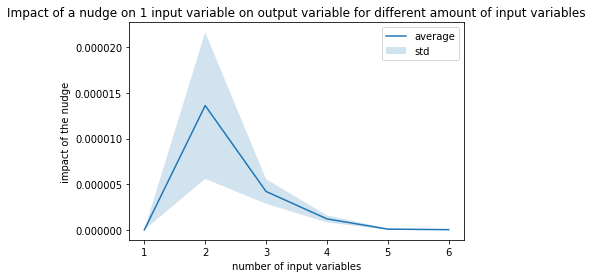

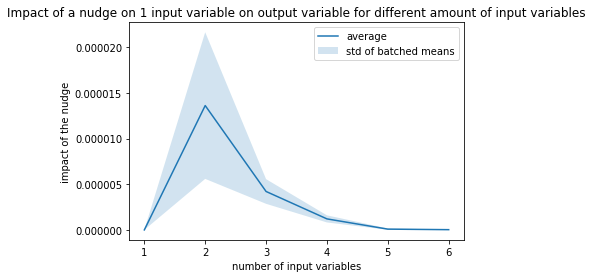

In [36]:
variable_range, mean_impact_nudge, std_impact_nudge, batches_std = (
    find_mean_std_mse(impact_nudge_dict, 1)
)

xlabel = "number of input variables"
ylabel = "impact of the nudge"
title = "Impact of a nudge on 1 input variable on output variable for different amount of input variables"
plotting.plot_mean_and_confidence(
    variable_range, mean_impact_nudge, std_impact_nudge,
    "std", xlabel, ylabel, title
)

plotting.plot_mean_and_confidence(
    variable_range, mean_impact_nudge, batches_std,
    "std of batched means", xlabel, ylabel, title
)

In [ ]:
NUMBER_OF_STATES, MAX_NUMBER_OF_VARIABLES NUDGE_SIZE = 6, 0.01
mutual_information_sizes = np.arange(0.05, 1, 0.05)
sample_size = 3
effect_nudge_given_mi = {}

for mutual_information_size in mutual_information_sizes:
    print("the mutual information size is {}".format(mutual_information_size))
    nudge_effects = []
    for sample in range(sample_size):
        pdf = JointProbabilityMatrix(1, NUMBER_OF_STATES, 'random')
        pdf.append_variables_with_target_mi(1, mutual_information_size)
        distribution = pdf.joint_probabilities.joint_probabilities
        nudge_effects.append(effect_of_nudge_1d(distribution, 0.01)[1])
        
    effect_nudge_given_mi[mutual_information_size] = nudge_effects
    
    
    

In [ ]:
import numpy as np

probability_array_tryout = FullNestedArrayOfProbabilities(
    np.array(
      [
        [
          [
            [0.2, 0.1]          
          ],
          [
            [0.05, 0.05]
          ]
        ],
        [
          [
            [0.3, 0.05] 
          ],
          [
            [0.15, 0.1] 
          ]
        ],
      ]
    )
) 

In [ ]:
def conditional_distribution(self, selected_indices, conditional_indices):
    """create the conditional distribution for the selected_indices given 
    the conditional_indices for the joint_distribution
    
    Parameters:
    ----------
    joint_distribution: numpy array
    selected_indices: list of integers
    conditional_indices: list of integers
    
    Returns:
    -------
    
    """
    joint_distribution = self.marginalize_distribution(selected_indices+conditional_indices)
    marginal_conditional = self.marginalize_distribution(conditional_indices)
    conditional_distribution = np.copy(joint_distribution) 
    it = np.iter(joint_distribution, flags='multi_index')
    while not it.finished:
        conditional_arguments = tuple([it.multi_index[i] for i in conditional_indices])
        conditional_distribution[it.multi_index] = (
            conditional_distribution[it.multi_index] /
            marginal_conditional[conditional_arguments]
        )
        it.iternext()
        
    return conditional_distribution
        

In [ ]:
import numpy as np

tryout = np.arange(2**10).reshape([2]*10)
#print(tryout)
a = [1, 3, 4, 5, 9]
total_variables = 10
b = np.moveaxis(tryout, a, range(total_variables-len(a), total_variables, 1))
c = np.array([[1,10],[100,1000]])
b = b*c
#tryout = np.moveaxis(b, range(total_variables-len(a), total_variables, 1), a)
print(tryout)


#tryout = b*c
#np.moveaxis(tryout, range(total_variables-len(a), total_variables, 1), a)
